In [11]:
# %% [markdown]
# tools/tavily_tool.py

# %%
from langchain_community.tools.tavily_search import TavilySearchResults

def get_tavily_tool():
    return TavilySearchResults(max_results=2)

In [12]:
# %% [markdown]
# tools/mcp_client_config.py

# %%
def get_mcp_config():
    return {
        "math": {
            "command": "python",
            "args": ["./math_server.py"],  # asegúrate de que esté en la ruta correcta
            "transport": "stdio",
        },
        "weather": {
            "url": "http://localhost:8000/sse",
            "transport": "sse",
        }
    }


In [13]:
# %% [markdown]
# graph/chatbot_graph.py

# %%
from langgraph.graph import StateGraph, MessagesState, START, END
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_openai import ChatOpenAI

def build_graph(tools):
    model = ChatOpenAI(model="gpt-4o-mini")
    llm_with_tools = model.bind_tools(tools)

    def call_model(state: MessagesState):
        response = llm_with_tools.invoke(state["messages"])
        return {"messages": response}

    builder = StateGraph(MessagesState)
    builder.add_node("call_model", call_model)
    builder.add_node("tools", ToolNode(tools))

    builder.add_edge(START, "call_model")
    builder.add_conditional_edges("call_model", tools_condition)
    builder.add_edge("tools", "call_model")
    builder.add_edge("call_model", END)

    return builder.compile()


In [14]:
# %% [markdown]
# main.py

# %%
import dotenv
import asyncio
from IPython.display import Image, display

from langchain_mcp_adapters.client import MultiServerMCPClient

# importa funciones definidas en las otras celdas
# si estás en un solo notebook, no necesitas cambiar nada
# si estuvieran en archivos separados, sería: from tools.tavily_tool import get_tavily_tool
get_tavily_tool = get_tavily_tool  # noqa
get_mcp_config = get_mcp_config    # noqa
build_graph = build_graph          # noqa

# %%
dotenv.load_dotenv()  # carga .env

# %%
async def main():
    async with MultiServerMCPClient(get_mcp_config()) as client:
        # Obtener herramientas del MCP
        mcp_tools = client.get_tools()
        print(f"Herramientas MCP disponibles ({len(mcp_tools)}):")
        for tool in mcp_tools:
            print(f"  - {tool.name}")

        # Agregar Tavily
        tools = mcp_tools + [get_tavily_tool()]

        # Construir grafo y mostrar diagrama
        graph = build_graph(tools)
        return graph


Herramientas MCP disponibles (5):
  - add
  - multiply
  - buscar_contratos_por_ruc
  - obtener_asistencias_congresista
  - buscar_votaciones_por_tema


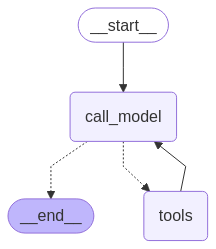

================================ Human Message =================================

what's 10 x 2 + 5?
None
================================== Ai Message ==================================
Tool Calls:
  multiply (call_KX2NcuDmJtfaM635PNP1r6To)
 Call ID: call_KX2NcuDmJtfaM635PNP1r6To
  Args:
    a: 10
    b: 2
  add (call_TfJtJ27psXGIQuWMWeAEyA60)
 Call ID: call_TfJtJ27psXGIQuWMWeAEyA60
  Args:
    a: 20
    b: 5
None
================================= Tool Message =================================
Name: multiply

Error: ClosedResourceError()
 Please fix your mistakes.
None
================================= Tool Message =================================
Name: add

Error: ClosedResourceError()
 Please fix your mistakes.
None
================================== Ai Message ==================================

It seems there was an error while trying to compute the values. However, I can do the calculation manually.

The equation is \(10 \times 2 + 5\).

1. First, calculate \(10 \times 2 = 20\).

{'messages': [HumanMessage(content="what's the weather in Cusco?", additional_kwargs={}, response_metadata={}, id='8b17a772-6053-4d94-a76c-becfa41ea363'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_YKmhqPPE9Py6N74MudQIsIXq', 'function': {'arguments': '{"query":"weather in Cusco"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 22, 'prompt_tokens': 187, 'total_tokens': 209, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_0392822090', 'id': 'chatcmpl-BUx3EaOKFbBscX3mHcx4CFrNcNJbJ', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--ce9eaca7-44bb-480f-9a0b-4d4e238703c5-0', tool_calls=[{'name': 'tavily_search_results_jso

In [15]:
# %% [markdown]
# Ejecutar main() y probar el grafo

# %%
graph = await main()
display(Image(graph.get_graph().draw_mermaid_png()))

# %%
agent_response = await graph.ainvoke({"messages": "what's 10 x 2 + 5?"})
for msg in agent_response["messages"]:
    print(msg.pretty_print())

# %%
await graph.ainvoke({"messages": "what's the weather in Cusco?"})


In [17]:
await graph.ainvoke({"messages": "Hola, que acciones puedo realizar?"})

{'messages': [HumanMessage(content='Hola, que acciones puedo realizar?', additional_kwargs={}, response_metadata={}, id='323dbbf4-f61b-471c-9713-c157c015edf3'),
  AIMessage(content='¡Hola! Aquí tienes algunas acciones que puedes realizar:\n\n1. **Buscar contratos por RUC**: Si tienes un RUC, puedo ayudarte a encontrar información sobre contratos relacionados.\n2. **Obtener asistencias de un congresista**: Proporciona el nombre de un congresista, y puedo mostrarte sus asistencias.\n3. **Buscar votaciones por tema**: Si hay un tema específico que te interesa, puedo buscar votaciones relacionadas con ese tema.\n4. **Realizar cálculos matemáticos**: Puedo sumar o multiplicar números.\n\nSi deseas realizar alguna de estas acciones, solo déjamelo saber y proporciona la información necesaria.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 135, 'prompt_tokens': 186, 'total_tokens': 321, 'completion_tokens_details': {'accepted_prediction_tokens': 

In [18]:
await graph.ainvoke({"messages": "what's the weather in Cusco?"})

{'messages': [HumanMessage(content="what's the weather in Cusco?", additional_kwargs={}, response_metadata={}, id='74fae21d-0132-4ff3-bc6e-beeec83fc43d'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_RzD8ctp0WdBG5spdKG9VqFZc', 'function': {'arguments': '{"query":"current weather in Cusco"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 23, 'prompt_tokens': 187, 'total_tokens': 210, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_0392822090', 'id': 'chatcmpl-BUx3huTAFSfUoQNnHhYa6nMfJZDmj', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--808534c3-3b1b-4ca6-9e77-5e9c30dabc53-0', tool_calls=[{'name': 'tavily_search_res